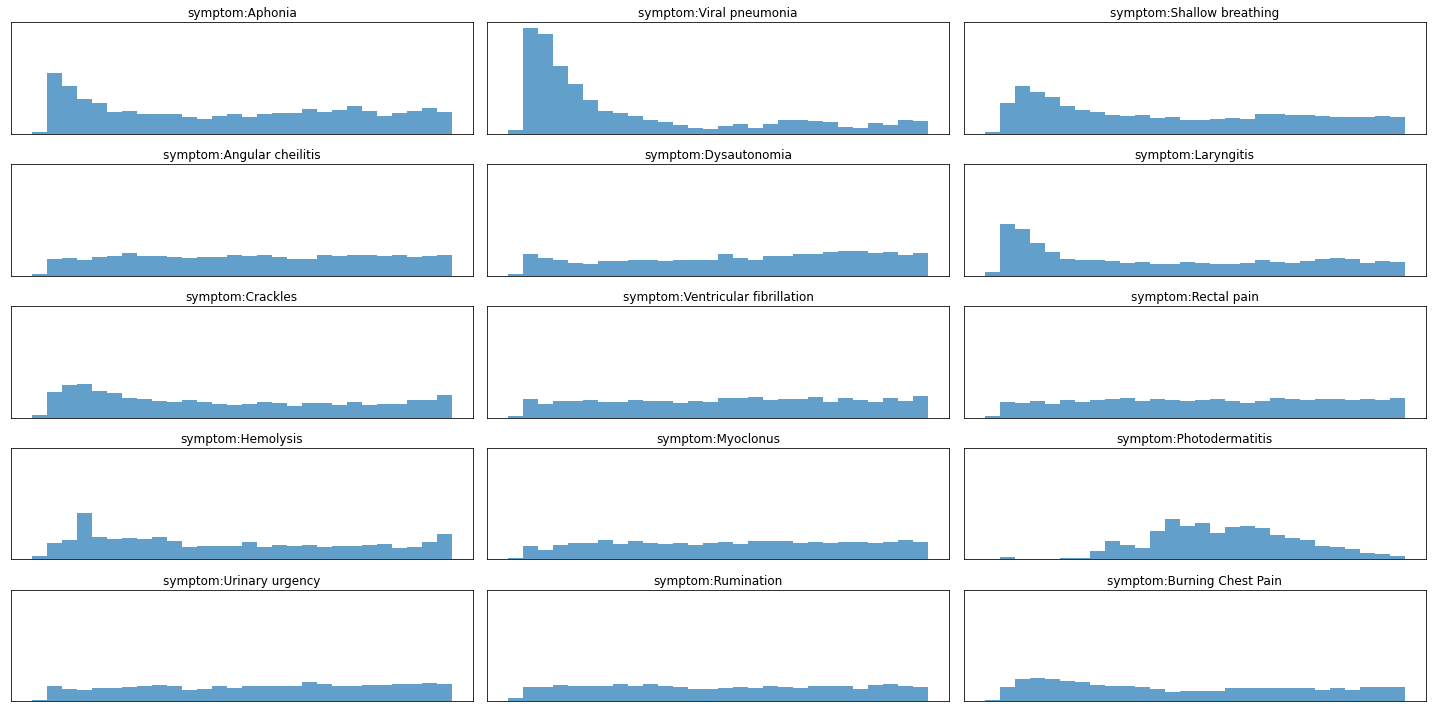

In [92]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('result.csv')
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
symptoms = pd.DataFrame(df[df.columns[3:-1]].sum(axis=0), columns=['sum']).\
    sort_values(by=['sum'], ascending=False).head(15).index.values

result = df.groupby('date').sum()[symptoms].reset_index()
# print(result.reset_index)

str = 'symptom:Aphonia'
fig, ax = plt.subplots(5,3, sharey=True, figsize=(20, 10))
count = 1
for i in range(0,5):
    for j in range(0,3):
        ax[i,j].bar(result.date, result.iloc[:, count], alpha=0.7, width=7)
        ax[i,j].set_title(symptoms[count-1])
        count+=1

for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()